In [1]:
%config IPCompleter.greedy=True ###TAB键补全代码

In [53]:
import os,sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import ast

In [55]:
### 1)加载数据
df = pd.read_csv('./iiwa_dataset.csv')
train_set = df.head(6000)
test_set = df.tail(df.shape[0]-6000)  
train_datas = [];train_labels = []
for rows in train_set.itertuples():
    _labels = ast.literal_eval(rows.Joint)
    _datas = ast.literal_eval(rows.Pose)
    train_datas.append(np.array(_datas).reshape(21,))
    train_labels.append(np.array(_labels).reshape(6,))
    
train_datas = np.array(train_datas)
train_labels = np.array(train_labels)

test_datas=[];test_labels=[]
for rows in test_set.itertuples():
    _labels = ast.literal_eval(rows.Joint)
    _datas = ast.literal_eval(rows.Pose)
    test_datas.append(np.array(_datas).reshape(21,))
    test_labels.append(np.array(_labels).reshape(6,))

test_datas = np.array(test_datas)
test_labels = np.array(test_labels)

In [56]:
print((train_datas.shape))

(6000, 21)


In [57]:
### 对数据进行归一化
train_datas_norm = tf.keras.utils.normalize(train_datas,axis=0,order=2)
test_datas_norm = tf.keras.utils.normalize(test_datas,axis=0,order=2)
print(train_datas_norm.shape)


(6000, 21)


In [58]:
print(test_datas_norm[0])

[-0.00460579  0.022575    0.01082556  0.02868916  0.02419516  0.0315995
 -0.01538903  0.0044043   0.02589713 -0.0029552   0.0284141   0.03375899
  0.0180912   0.00619129  0.0352622   0.02102077  0.01177144  0.03147051
  0.02381399  0.01133825  0.03631913]


In [65]:
### 2)搭建网络
model = keras.Sequential([
            keras.layers.Flatten(input_shape=(1,21)),
            keras.layers.Dense(1000,activation='tanh'),
            keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            #keras.layers.Dense(1000,activation='tanh'),
            keras.layers.Dense(6,activation=None)
        ])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 1000)              22000     
_________________________________________________________________
dense_85 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_86 (Dense)             (None, 6)                 6006      
Total params: 1,029,006
Trainable params: 1,029,006
Non-trainable params: 0
_________________________________________________________________


In [66]:
def rmsle(y_true,y_predict):
    msle=tf.keras.losses.MeanSquaredLogarithmicError()
    return keras.backend.sqrt(msle(y_true,y_predict))

In [73]:
import os,sys
os.chdir(".")
lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 29 (delta 15), reused 19 (delta 9), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [82]:
import levenberg_marquardt as lm
import time
input_size = 20000
batch_size = 1000

x_train = np.linspace(-1, 1, input_size, dtype=np.float64)
y_train = np.sinc(10 * x_train)

x_train = tf.expand_dims(tf.cast(x_train, tf.float32), axis=-1)
y_train = tf.expand_dims(tf.cast(y_train, tf.float32), axis=-1)

In [83]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(input_size)
train_dataset = train_dataset.batch(batch_size).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [84]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(1, activation='linear')])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

In [86]:
model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
    loss=lm.MeanSquaredError())
print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

Train using Adam
Epoch 1/1000
20/20 [==============================] - 1s 2ms/step - loss: 0.0535
Epoch 2/1000
20/20 [==============================] - 0s 984us/step - loss: 0.0475
Epoch 3/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0470
Epoch 4/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 5/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 6/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 7/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0465
Epoch 8/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 9/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 10/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 11/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0456
Epoch 12/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0453
Epoch 

20/20 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 101/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 102/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 103/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 104/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 105/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 106/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 107/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 108/1000
20/20 [==============================] - 0s 912us/step - loss: 0.0194
Epoch 109/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 110/1000
20/20 [==============================] - 0s 928us/step - loss: 0.0184
Epoch 111/1000
20/20 [==============================] - 0s 892us/step - loss: 0.0180
Epoch 112/100

20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 199/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 200/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 201/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 202/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 203/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 204/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 205/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 206/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 207/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 208/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 209/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 210/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 297/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 298/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 299/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 300/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 301/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 302/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 303/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 304/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 305/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 306/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 307/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 308/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 395/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 396/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 397/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 398/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 399/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 400/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 401/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 402/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 403/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 404/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 405/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 406/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 493/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 494/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 495/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 496/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 497/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 498/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 499/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 500/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 501/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 502/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 503/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 504/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 591/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 592/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 593/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 594/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 595/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 596/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 597/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 598/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 599/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 600/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 601/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 602/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 689/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 690/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 691/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 692/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 693/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 694/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 695/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 696/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 697/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 698/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 699/1000
20/20 [==============================] - 0s 994us/step - loss: 0.0014
Epoch 700/1000
20

20/20 [==============================] - 0s 953us/step - loss: 0.0013
Epoch 787/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 788/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 789/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 790/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 791/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 792/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 793/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 794/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 795/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 796/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 797/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 798/1000
20

20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 885/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 886/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 887/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 888/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 889/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 890/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 891/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 892/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 893/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 894/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 895/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 896/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 983/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 984/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 985/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 986/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 987/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 988/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 989/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 990/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 991/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 992/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 993/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 994/1000
20/2

### 训练网络
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt,loss=rmsle)
model.fit(train_datas_norm,train_labels,epochs=20)

print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

In [87]:
print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)


_________________________________________________________________
Train using Levenberg-Marquardt
Epoch 1/100
20/20 [==============================] - 2s 47ms/step - damping_factor: 1.0000e-04 - attempts: 3.0000 - loss: 0.0243
Epoch 2/100
20/20 [==============================] - 1s 46ms/step - damping_factor: 1.0000e-05 - attempts: 1.0000 - loss: 0.0032
Epoch 3/100
20/20 [==============================] - 1s 47ms/step - damping_factor: 1.0000e-04 - attempts: 3.0000 - loss: 0.0019
Epoch 4/100
20/20 [==============================] - 1s 45ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0012
Epoch 5/100
20/20 [==============================] - 1s 48ms/step - damping_factor: 1.0000e-06 - attempts: 2.0000 - loss: 9.2152e-04
Epoch 6/100
20/20 [==============================] - 1s 46ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 7.7740e-04
Epoch 7/100
20/20 [==============================] - 1s 47ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - los


_________________________________________________________________
Plot results


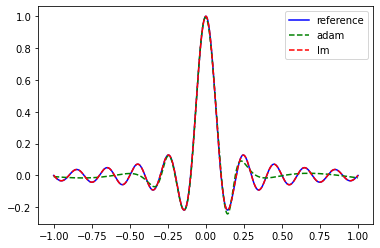

In [89]:
import matplotlib.pyplot as plt
print("\n_________________________________________________________________")
print("Plot results")
plt.plot(x_train, y_train, 'b-', label="reference")
plt.plot(x_train, model.predict(x_train), 'g--', label="adam")
plt.plot(x_train, model_wrapper.predict(x_train), 'r--', label="lm")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import time
import levenberg_marquardt as lm

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.cast(x_train / 255.0, dtype=tf.float32)
x_test = tf.cast(x_test / 255.0, dtype=tf.float32)

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(60000)
train_dataset = train_dataset.batch(6000).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='valid',
                           activation='tanh', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=4, strides=2, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='linear')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

model_wrapper = lm.ModelWrapper(tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.SparseCategoricalCrossentropy(from_logits=True),
    solve_method='solve',
    metrics=['accuracy'])

print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=200)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=10)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

print("\n_________________________________________________________________")
print("Test set results")

test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
print("adam - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))

test_loss, test_acc = model_wrapper.evaluate(x=x_test, y=y_test, verbose=0)
print("lm - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))

11501568/11490434 [==============================] - 10s 1us/step
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 4)           516       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 4)           68        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 4)           68        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           68        
_________________________________________________________________
flatten_12 (Flatten)         (None, 16)                0         
_____________________________________________________

10/10 [==============================] - 1s 142ms/step - loss: 0.1220 - accuracy: 0.9646
Epoch 67/200
10/10 [==============================] - 1s 140ms/step - loss: 0.1228 - accuracy: 0.9643
Epoch 68/200
10/10 [==============================] - 1s 142ms/step - loss: 0.1190 - accuracy: 0.9651
Epoch 69/200
10/10 [==============================] - 1s 141ms/step - loss: 0.1218 - accuracy: 0.9643
Epoch 70/200
10/10 [==============================] - 1s 138ms/step - loss: 0.1172 - accuracy: 0.9658
Epoch 71/200
10/10 [==============================] - 1s 142ms/step - loss: 0.1203 - accuracy: 0.9645
Epoch 72/200
10/10 [==============================] - 1s 142ms/step - loss: 0.1153 - accuracy: 0.9661
Epoch 73/200
10/10 [==============================] - 1s 141ms/step - loss: 0.1171 - accuracy: 0.9656
Epoch 74/200
10/10 [==============================] - 1s 141ms/step - loss: 0.1140 - accuracy: 0.9663
Epoch 75/200
10/10 [==============================] - 1s 141ms/step - loss: 0.1155 - accuracy: 

Epoch 146/200
10/10 [==============================] - 1s 144ms/step - loss: 0.0841 - accuracy: 0.9750
Epoch 147/200
10/10 [==============================] - 1s 143ms/step - loss: 0.0829 - accuracy: 0.9754
Epoch 148/200
10/10 [==============================] - 1s 140ms/step - loss: 0.0824 - accuracy: 0.9759
Epoch 149/200
10/10 [==============================] - 1s 140ms/step - loss: 0.0839 - accuracy: 0.9751
Epoch 150/200
10/10 [==============================] - 1s 141ms/step - loss: 0.0918 - accuracy: 0.9725
Epoch 151/200
10/10 [==============================] - 1s 139ms/step - loss: 0.0902 - accuracy: 0.9727
Epoch 152/200
10/10 [==============================] - 1s 138ms/step - loss: 0.0842 - accuracy: 0.9749
Epoch 153/200
10/10 [==============================] - 1s 141ms/step - loss: 0.0841 - accuracy: 0.9748
Epoch 154/200
10/10 [==============================] - 1s 139ms/step - loss: 0.0828 - accuracy: 0.9758
Epoch 155/200
10/10 [==============================] - 1s 140ms/step - lo